<a href="https://colab.research.google.com/github/kristinapohl/DeepLearning/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder & Variational Autoencoder am Beispiel von FashionMNIST

In dieser Aufgabe geht es darum, einen Autoencoder und einen Variational Autoencoder für den *FashionMNIST* Datensatz zu trainieren.

In [10]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d pacificrm/car-insurance-fraud-detection


Dataset URL: https://www.kaggle.com/datasets/pacificrm/car-insurance-fraud-detection
License(s): CC0-1.0
 97% 799M/826M [00:04<00:00, 147MB/s]
100% 826M/826M [00:04<00:00, 211MB/s]


In [ ]:
!unzip car-insurance-fraud-detection.zip -d data


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/100.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1002.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1005.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1006.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1007.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1008.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1009.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1010.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train/Non-Fraud/1011.jpg  
  inflating: data/Insurance-Fraud-Detection/Insurance-Fraud-D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Daten laden

Zunächst laden wir wieder die Trainings- und Testdaten.

In [8]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder(
    root="/content/data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train",
    transform=transform
)

test_set = datasets.ImageFolder(
    root="/content/data/Insurance-Fraud-Detection/Insurance-Fraud-Detection/test",
    transform=transform
)

print("Train-Klassen:", train_set.classes)
print("Test-Klassen:", test_set.classes)
print("Anzahl Trainingsbilder:", len(train_set))
print("Anzahl Testbilder:", len(test_set))

Train-Klassen: ['Fraud', 'Non-Fraud']
Test-Klassen: ['Fraud', 'Non-Fraud']
Anzahl Trainingsbilder: 5200
Anzahl Testbilder: 1416


# Neuer Abschnitt

In [11]:
batch_size = 512

transform_image = transforms.Compose([transforms.ToTensor(),])

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=20, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, num_workers=20, shuffle=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Trainingsbilder visualisieren**

Die ersten Trainingsdaten werdeb geladen und Beispiele für verschiedene Klassen angegeben.
Die Daten werden einem Data Loader für die Zufallsverteilung und eine Organisation in "batches" übergeben.

TypeError: Invalid shape (3, 224, 224) for image data

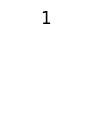

In [12]:
for images, labels in train_loader:  # damit wir die Fotos und die Zahlen bekommen
    # Erste Batch von Daten laden
    break

figure = plt.figure()
num_images = 18
for i in range(num_images):
    plt.subplot(3, 6, i+1, title=f"{labels[i]}")
    plt.axis("off")
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap="gray_r")

## Autoencoder: Definition des Encoders und Decoders

Der *Encoder* transformiert jedes Bild (28x28 Pixel) in einen *latenten Raum* von niedriger Dimension. Die Dimension dieses Raumes sollten Sie als Parameter `latent_size` übergeben, damit wir die Größe später variieren können.

Als Architektur können Sie in Ihren Gruppen zwei Ansätze ausprobieren:

- Ein einfaches Netz bestehend aus zwei [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) Layern mit [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) als Aktivierungsfunktion
- Ein mehrschichtiges CNN mit drei Blöcken aus [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) und [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). Wie in der Aufgabe zur Bildklassifikation
  sollten Sie dabei die Zahl der Pixel verringern und die Zahl der Kanäle erhöhen. Am Ende hängen Sie einen [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)  Layer an, der das Bild in
  den latenten Raum transferiert.
  
Der *Decoder* besteht aus der umgekehrten Architektur wie der *Encoder* (Tipp: [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) können Sie mit [`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) "umdrehen").

**Welche Aktivierungsfunktion sollten Sie am Ende verwenden, um Grauwerte im Bereich zwischen 0 und 1 zu erzeugen?**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Die folgende Hilfsfunktion verwenden wir bei der Kontrollausgabe der Bilder

In [ ]:
def to_image(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Vorbereitung des Trainings

Zum Training wählen Sie eine geeignete `latent_size`, eine Verlustfunktion `criterion` und einen Optimizer aus.

In [ ]:
number_epochs = 31
latent_size = # YOUR CODE HERE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Autoencoder(latent_size)
model = model.to(device)

criterion = # YOUR CODE HERE
optimizer = # YOUR CODE HERE

train_loss = []
test_loss = []

In [ ]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        running_loss = 0
        count = 0
        for data in train_loader:
            optimizer.zero_grad()

            image, i = data
            image = image.to(device)

            # Forward pass
            output = model(image)
            loss = criterion(output, image)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += 1
        train_loss.append(running_loss/count)

        with torch.no_grad():
            running_loss = 0
            count = 0
            for data in test_loader:
                image, i = data
                image = image.to(device)

                # Forward pass
                output = model(image)
                loss = criterion(output, image)
                running_loss += loss.item()
                count += 1
            test_loss.append(running_loss/count)

            iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
            if epoch % 10 == 0:
                rec = to_image(output.cpu().data)
                img = to_image(image.cpu().data)
                save_image(rec, f"rec_{epoch}.png")
                save_image(img, f"img_{epoch}.png")

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label="train_loss")
plt.plot(range(len(test_loss)), test_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

## Teil 2: Variational Autoencoder

Beim Variational Autoencoder erzeugt der *Encoder* zu einer Eingabe keinen festen Ausgabevektor, sondern eine Normalverteilung $N(\mu, \sigma)$.
Der Encoder liefert dazu zwei Werte $\mu$ und $\log(\sigma),$ die jeweils die Dimension `latent_size` haben.

Mit diesen Parametern "würfelt" der Autoencoder einen Wert, den er dann an den *Decoder* übergibt. Dazu dient die Methode `reparametrize`

Die Verlustfunktion setzt sich dann aus dem Rekonstruktionsverlust $D_{RL}$ und der *Kullback-Leibler Divergenz* der Verteilung zur Standardnormalverteilung

$$D_{KL}[N(\mu, \sigma), N(0, 1)] = -\frac{1}{2} \sum(1+ log(\sigma^2) - \mu^2 - \sigma^2)$$

zusammen:

$$D = D_{RL} + \beta D_{KL}.$$

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        ## YOUR CODE HERE

    def forward(self, x):
        ## YOUR CODE HERE
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        ## YOUR CODE HERE

    def forward(self, x):
        ## YOUR CODE HERE
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        x = self.reparametrize(mu, logvar)
        x = self.decoder(x)
        return x, mu, logvar

In [ ]:
class KLDLoss(nn.Module):
    """Calculate Kullback-Leibler divergence between learned mean and logvar and standard normal distribution.
    This is *NOT* a re-implementation of torch.nn.KLDivLoss"""
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

In [ ]:
number_epochs = 31
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

beta = ## YOUR CODE HERE

model = VariationalAutoencoder(latent_size)
model = model.to(device)

reconstruction_loss = ## YOUR CODE HERE
kld_loss = ## YOUR CODE HERE

optimizer = ## YOUR CODE HERE

train_loss = []
test_loss = []

In [ ]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        running_loss = 0
        count = 0
        model.train()
        for data in train_loader:
            optimizer.zero_grad()

            image, i = data
            image = image.to(device)

            # Forward pass
            output, mean, logvar = model(image)
            rc_loss = ## YOUR CODE HERE
            kl_loss = ## YOUR CODE HERE
            loss = rc_loss + beta * kl_loss

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += 1
        train_loss.append(running_loss/count)

        with torch.no_grad():
            running_loss = 0
            count = 0
            for data in test_loader:
                image, i = data
                image = image.to(device)

                # Forward pass
                output, mean, logvar = model(image)
                rc_loss = ## YOUR CODE HERE
                kl_loss = ## YOUR CODE HERE
                loss = rc_loss + beta * kl_loss
                running_loss += loss.item()
                count += 1
            test_loss.append(running_loss/count)

            iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
            if epoch % 10 == 0:
                rec = to_image(output.cpu().data)
                img = to_image(image.cpu().data)
                save_image(rec, f"rec_{epoch}.png")
                save_image(img, f"img_{epoch}.png")

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label="train_loss")
plt.plot(range(len(test_loss)), test_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()